In [ ]:
%matplotlib inline

# LSTMハンズオン

今回はkerasを利用した時系列データの予測を行います。

- 規則性のある波を予測 (値1つで予測)
- 規則性のあるアイスクリームの売り上げ予測 (売り上げだけではなく気温など複数の値を考慮して予測)
- 規則性のないbitcoinの値段を予測 (最終取引価格や最高売り価格などで予測)
- おまけでword2vec

## 1 規則性のある波を予測 (値1つで予測)

### 1-1 データセットの作成

機械学習する上でまずデータセットが必要になります。データセットは、入力と出力、今回は時系列データとその後の値が必要になります。

まずは学習に使うデータをsinを作ります。

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# sin波生成
def sin(length=100, curve=4):
    x = np.arange(0, length)
    return np.sin((curve * np.pi) * x / length)

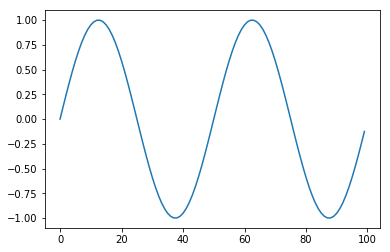

In [6]:
plt.plot(sin())
plt.show()

このままでは単純にsinを計算すれば求められるので、ある程度ノイズを乗せて予測しずらそうなデータにします。

In [11]:
# ノイズ付きsin波
def noised_sin(length=100, curve=4, noise_rate=0.3, low=-1.0, high=1.0):
    x = sin(length=length, curve=curve)
    noise = noise_rate * np.random.uniform(low=low, high=high, size=len(x))
    return x + noise

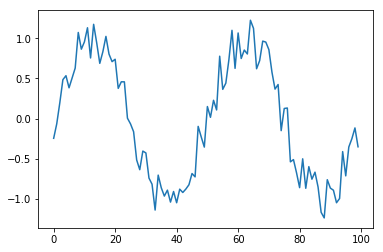

In [12]:
plt.plot(noised_sin())
plt.show()

ノイズを乗せれたので今度はデータを時系列データとして整形します。

時系列データの学習では数個の連続したデータを1セットとして用意する必要があります。

以下の関数で配列をstep個に分けたデータセットと答え(次の値)を作れます。

戻り値はnumpyで作られたarray like object(配列っぽいオブジェクト)です。

In [24]:
def create_reccurent_dataset(vector_data, step=25):
    data, target = [], []
    for i in range(len(vector_data) - step):
        data.append(vector_data[i:(i + step)])
        target.append(vector_data[i + step])
    reshape_data = np.array(data).reshape(len(data), step, 1)
    reshape_label = np.array(target).reshape(len(data), 1)
    return reshape_data, reshape_label

適当な値を入れてみて、データの形状と中身の確認をしてみましょう。

In [26]:
train_data, train_label = create_reccurent_dataset([1,2,3,4,5,6,7,8,9], 3)

In [30]:
# np_array.shape = 多次元配列版 length
train_data.shape

(6, 3, 1)

トレーニングデータは3個の連続した値を6つ持った配列になります。

具体的には、(学習データ総数, 1学習の時系列数(ステップ数), 特徴量)で整形する必要があります。

3次元配列で出てきますが、他にも気温、湿度、曜日など予測に役立ちそうなデータを入れられます。(今回は1つのデータなので三番目は1になってます)

次に中身も確認してみましょう。

In [31]:
train_data

array([[[1],
        [2],
        [3]],

       [[2],
        [3],
        [4]],

       [[3],
        [4],
        [5]],

       [[4],
        [5],
        [6]],

       [[5],
        [6],
        [7]],

       [[6],
        [7],
        [8]]])

連続した値を3つずつ分割して計6個の学習用データが入っています。

次に答えラベル(次に来るべき値)も確認してみます。

In [32]:
train_label.shape

(6, 1)

トレーニングデータ6個に対して6つの答えラベルが用意できています。

中身も確認してみましょう

In [33]:
train_label

array([[4],
       [5],
       [6],
       [7],
       [8],
       [9]])

[1,2,3]の答えとして4、[2,3,4]の答えとして5

答えも用意できました。

では、実際にノイズつきデータをデータセットとして整形してみましょう。

length(データ個数)やnoise_rate(ノイズの度合い)をあげたり、curve(カーブ数)を変えてもらっても構いません！

In [34]:
# ノイズ付きsin波予測
data = noised_sin(length=100, curve=4, noise_rate=0.3)
train_data, train_label = create_reccurent_dataset(data, step=25)

In [35]:
train_data.shape

(75, 25, 1)

In [36]:
train_label.shape

(75, 1)

パラメータ変えていなければ25個の連続したデータが75個できたと思います。

## 1-2 モデル構築

時系列(長短期記憶)学習モデルは今回使用するLSTM以外にもたくさんあります。QRNNが新しく、良さそう

- RNN
- LSTM
- [QRNN](https://qiita.com/icoxfog417/items/d77912e10a7c60ae680e)


tensorflow内蔵のkerasを利用します。(kerasはtensorflowのラッパーです)

In [38]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping

In [39]:
# 1つの学習データのStep数(今回は25)
step_count = 25

# 特徴量 今回の学習するデータは1個のみ
feature_count = 1

# https://keras.io/ja/layers/recurrent/#lstm
# 公式は:出力の次元数ですが、LSTMの次に全層結合を挟むので中間層の数(間違ってたらすいませんw)
# LSTMの第一引数は出力の次元数ですが、LSTMの次に全層結合(Dense)を挟むので中間層の数になります
# (間違ってたらすいませんw)
hidden_unit_count = 300

In [40]:
model = Sequential()
model.add(
    LSTM(
        hidden_unit_count,
        batch_input_shape=(None, step_count, feature_count), # 入力 (データ数(未知数なのでNone), step数, 特徴数)
        return_sequences=False
    )
)
model.add(Dense(feature_count)) # LSTMからでた300個のノードを1つの値にまとめます。
model.add(Activation('linear')) # 活性化関数 他にもsoftmaxとかsigmoidとかreluとか
optimizer = Adam(lr=0.001) # 最適化関数にadamを利用し、学習率0.001でトレーニング

model.compile(loss='mean_squared_error', optimizer=optimizer)

In [50]:

# TODO: plot model
# from tensorflow.python.keras.utils import plot_model

# from tensorflow.python.keras.utils.vis_utils import model_to_dot 

# import tensorflow.python.keras
# dir(keras)

# plot_model(model)
model.output_shape

(None, 1)

In [ ]:
# 早期終了 過学習抑制、打ち切る手法 過学習(Over fitting)に陥ることを避けつつ、簡単にエポック数を考える手間を減らすことができる
# 30~50epochsくらいで十分学習できたと判断して終了するはず
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=300,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [ ]:
# 推論、検証
predictions = model.predict(train_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.legend()
plt.show()

In [ ]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 25, 1))
    batch_predict = model.predict(test_data)

    # 結果蓄積
    results = np.append(results, batch_predict)

    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (50)から(50,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [ ]:
# 多変量LSTMでアイスクリームの売り上げ予測 (ある程度規則性のあるデータで、売上だけではなく気温なども考慮した予測)
# 参考データ(使いやすいように加工してます): https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html

import pandas

In [ ]:
data = pandas.read_csv('volume/datasets/tokyo-weather-and-ice-sales.csv')
data

In [ ]:
# year, month, avg_max_temperature, sum_precipitation_mm, avg_humidity_per, 25c_days, ice_sale
plt.plot(data['avg_max_temperature'], label='avg_max_temperature') # 最大気温平均
plt.plot(data['sum_precipitation_mm'], label='sum_precipitation_mm') # 合計降水量
plt.plot(data['avg_humidity_per'], label='avg_humidity_per') # 平均湿度
plt.plot(data['25c_days'], label='25c_days') # 25度以上の日数
plt.plot(data['ice_sale'], label='ice_sale') # アイスの売り上げ(円)
plt.legend()
plt.show()

In [ ]:
# 最大気温平均, 合計降水量, 平均湿度, 25度以上の日数をもとに`アイスの売り上げ(円)`を予測します

temps = data['avg_max_temperature'].values.tolist() # 配列化
temps = np.array(temps).reshape((len(temps), 1)) # 形状変更 (120, 1)
print(temps.shape)

precs = data['sum_precipitation_mm'].values.tolist() # 配列化
precs = np.array(precs).reshape((len(precs), 1)) # 形状変更 (120, 1)
print(precs.shape)

humidities = data['avg_humidity_per'].values.tolist() # 配列化
humidities = np.array(humidities).reshape((len(humidities), 1)) # 形状変更 (120, 1)
print(humidities.shape)

up25days = data['25c_days'].values.tolist() # 配列化
up25days = np.array(up25days).reshape((len(up25days), 1)) # 形状変更 (120, 1)
print(up25days.shape)

icesales = data['ice_sale'].values.tolist() # 配列化
icesales = np.array(icesales).reshape((len(icesales), 1)) # 形状変更 (120, 1)
print(icesales.shape)

In [ ]:
# 標準化
# すべての値を0~1の範囲に納める
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

normalized_temps = scaler.fit_transform(temps)
normalized_precs = scaler.fit_transform(precs)
normalized_humidities = scaler.fit_transform(humidities)
normalized_up25days = scaler.fit_transform(up25days)
normalized_icesales = scaler.fit_transform(icesales)

In [ ]:
normalized_icesales[0:10]

In [ ]:
# 一年周期で変動する月のデータなので12step
# 余談、ちょくちょくデータ内容確認した方がいい。normalized_icesalesをicesalesとtypoしてicesalesだけ300倍率くらいのデータになって学習時にハマる。。
temps_train_data, temps_train_label = create_reccurent_dataset(normalized_temps, step=12)
precs_train_data, precs_train_label = create_reccurent_dataset(normalized_precs, step=12)
up25days_train_data, up25days_train_label = create_reccurent_dataset(normalized_up25days, step=12)
humidities_train_data, humidities_train_label = create_reccurent_dataset(normalized_humidities, step=12)
icesales_train_data, icesales_train_label = create_reccurent_dataset(normalized_icesales, step=12)
print(temps_train_data.shape)
print(temps_train_label.shape)
print(precs_train_data.shape)
print(precs_train_label.shape)
print(up25days_train_data.shape)
print(up25days_train_label.shape)
print(humidities_train_data.shape)
print(humidities_train_label.shape)
print(icesales_train_data.shape)
print(icesales_train_label.shape)

In [ ]:
# 推論する際の形状 = (個数, ステップ数, 特徴量(最大気温平均, 合計降水量, 平均湿度, 25度以上の日数))
# 今回の推論時の形状 = (個数, 12, 5)
# 入力も出力も最大気温平均, 合計降水量, 平均湿度, 25度以上の日数, アイスの売り上げ(円)の5つ
train_data = np.c_[temps_train_data, precs_train_data, up25days_train_data, humidities_train_data, icesales_train_data]
train_label = np.c_[temps_train_label, precs_train_label, up25days_train_label, humidities_train_label, icesales_train_label]
print(train_data.shape)
print(train_label.shape)

# train_data[0:5]
# train_label[0:5]

In [ ]:
# モデル構築
step_count = 12
feature_count = 5
hidden_unit_count = 120

model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count)))
model.add(Dense(feature_count))
model.add(Activation('linear'))
optimizer = Adam(lr=0.003)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [ ]:
# 推論、検証
predictions = model.predict(train_data)
predictions[0:5]

In [ ]:
# 最大気温平均
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label temp')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions temp')
plt.legend()
plt.show()

In [ ]:
# 合計降水量
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 0.7, 1.0), label='train_label prec')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 0.0, 1.0), label='predictions prec')
plt.legend()
plt.show()

In [ ]:
# 平均湿度
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 1.0, 1.0), label='train_label humidity')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 1.0, 1.0), label='predictions humidity')
plt.legend()
plt.show()

In [ ]:
# 25度以上の日数
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,3], color=(1.0, 1.0, 0.7), label='train_label 25c_days')
plt.plot(range(0, len(predictions)), predictions[:,3], color=(1.0, 1.0, 0.0), label='predictions 25c_days')
plt.legend()
plt.show()

In [ ]:
# アイスの売り上げ
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,4], color=(0.7, 1.0, 1.0), label='train_label ice_sale')
plt.plot(range(0, len(predictions)), predictions[:,4], color=(0.0, 1.0, 1.0), label='predictions ice_sale')
plt.legend()
plt.show()

In [ ]:
# すべて
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label temp')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions temp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 0.7, 1.0), label='train_label prec')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 0.0, 1.0), label='predictions prec')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 1.0, 1.0), label='train_label humidity')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 1.0, 1.0), label='predictions humidity')
plt.plot(range(0, len(train_label)), train_label[:,3], color=(1.0, 1.0, 0.7), label='train_label 25c_days')
plt.plot(range(0, len(predictions)), predictions[:,3], color=(1.0, 1.0, 0.0), label='predictions 25c_days')
plt.plot(range(0, len(train_label)), train_label[:,4], color=(0.7, 1.0, 1.0), label='train_label ice_sale')
plt.plot(range(0, len(predictions)), predictions[:,4], color=(0.0, 1.0, 1.0), label='predictions ice_sale')
plt.legend()
plt.show()

In [ ]:
# 未来予測 5ヶ月後
latest_data = np.array([train_data[len(train_data)-1]])
results = []
for _ in range(5):
    # 推論
    print(latest_data.shape)
    batch_predict = model.predict(latest_data)
    # 結果蓄積
    results.append([batch_predict[0][0], batch_predict[0][1], batch_predict[0][2], batch_predict[0][3], batch_predict[0][4]])
    # 次のデータをセット
    latest_data = np.delete(latest_data, np.array([batch_predict]), axis=1)
    latest_data = np.append(latest_data, np.array([batch_predict]), axis=1)
results = np.array(results)
results.shape

In [ ]:
plt.figure()

plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label temp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 0.7, 1.0), label='train_label prec')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 1.0, 1.0), label='train_label humidity ')
plt.plot(range(0, len(train_label)), train_label[:,3], color=(1.0, 1.0, 0.7), label='train_label 25c_days')
plt.plot(range(0, len(train_label)), train_label[:,4], color=(0.7, 1.0, 1.0), label='train_label ice_sale')

plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,0], color=(1.0, 0.0, 0.0), label='future temp')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,1], color=(0.0, 0.0, 1.0), label='future prec')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,2], color=(0.0, 1.0, 1.0), label='future humidity')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,3], color=(1.0, 1.0, 0.0), label='future 25c_days')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,4], color=(0.0, 1.0, 1.0), label='future ice_sales')

plt.legend()
plt.show()

In [ ]:
# pybitflyer データ取得

In [ ]:
import pybitflyer

In [ ]:
api = pybitflyer.API()
data = api.ticker(product_code='BTC_JPY')

In [ ]:
data

In [ ]:
print(data['ltp']) # 最終取引価格
print(data['best_ask']) # 最高買い価格
print(data['best_bid']) # 最小売り価格

In [ ]:
# 単変量のLSTM
# まずは最終取引価格だけで最終取引価格を予測

In [ ]:
import time
from datetime import datetime

In [ ]:
btc_jpy_data = []
count = 5
api = pybitflyer.API()
while True:
    tick = api.ticker(product_code='BTC_JPY')
    print('tick={} ltp={}'.format(len(btc_jpy_data), tick['ltp']))
    btc_jpy_data.append(tick)
    time.sleep(1)
    if count <= len(btc_jpy_data):
        break

In [ ]:
btc_jpy_data

In [ ]:
# ファイルから
import json
with open('volume/datasets/BTC_JPY.json', 'r') as f:
    btc_jpy_data = json.load(f)

In [ ]:
btc_jpy_data

In [ ]:
# ltpだけ利用
data = [[d['ltp']] for d in btc_jpy_data]

In [ ]:
data

In [ ]:
plt.figure()
plt.plot(range(0, len(data)), data, color='r', label='data')
plt.legend()
plt.show()

In [ ]:
# 標準化
# すべての値を0~1の範囲に納める
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)
print(normalized_data)

In [ ]:
train_data, train_label = create_reccurent_dataset(normalized_data, step=5)
print(train_data.shape)
print(train_label.shape)

In [ ]:
# モデル構築
# 学習率の調整がキモ?? 0.00001だと200stepでも不安定、0.0001なら50step程度でEarlyStoppingする
step_count = 5
feature_count = 1
hidden_unit_count = 300
model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(feature_count))
model.add(Activation('linear'))
optimizer = Adam(lr=0.0001) # 学習率 0.001 -> 0.003 -> 0.03 -> 0.01
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=0)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [ ]:
model.predict(np.array([[[1.0],[0.8],[0.6],[0.4],[0.2]]]))[0][0]

In [ ]:
model.predict(np.array([[[0.0],[0.0],[0.0],[0.0],[0.0]]]))[0][0]

In [ ]:
model.predict(np.array([[[1.0],[1.0],[1.0],[1.0],[1.0]]]))[0][0]

In [ ]:
model.predict(np.array([[[0.2],[0.4],[0.6],[0.8],[1.0]]]))[0][0]

In [ ]:
# 推論、検証
predictions = model.predict(train_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.legend()
plt.show()

In [ ]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 5, 1))
    batch_predict = model.predict(test_data)
    # 結果蓄積
    results = np.append(results, batch_predict)
    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (個数)から(個数,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [ ]:
# 多変量のLSTM
# 利用する特徴 ltp, best_ask, best_bid

In [ ]:
ltp_data = np.array([[d['ltp']] for d in btc_jpy_data])
best_ask_data = np.array([[d['best_ask']] for d in btc_jpy_data])
best_bid_data = np.array([[d['best_bid']] for d in btc_jpy_data])

In [ ]:
# 標準化
scaler = MinMaxScaler(feature_range=(0, 1))
ltp_data = scaler.fit_transform(ltp_data)
best_ask_data = scaler.fit_transform(best_ask_data)
best_bid_data = scaler.fit_transform(best_bid_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(ltp_data)), ltp_data, color='r', label='ltp')
plt.plot(range(0, len(best_ask_data)), best_ask_data, color='g', label='best_ask')
plt.plot(range(0, len(best_bid_data)), best_bid_data, color='b', label='best_bid')
plt.legend()
plt.show()

In [ ]:
ltp_train_data, ltp_train_label = create_reccurent_dataset(ltp_data, step=5)
best_ask_train_data, best_ask_train_label = create_reccurent_dataset(best_ask_data, step=5)
best_bid_train_data, best_bid_train_label = create_reccurent_dataset(best_bid_data, step=5)

In [ ]:
print(ltp_train_data.shape)
print(best_ask_train_data.shape)
print(best_bid_train_data.shape)

In [ ]:
print(ltp_train_label.shape)
print(best_ask_train_label.shape)
print(best_bid_train_label.shape)

In [ ]:
# 推論する際の形状 = (個数, ステップ数, 特徴量)
# 前回の推論時の形状 = (個数, 5, 1)
# 今回の推論時の形状 = (個数, 5, 3)
# 入力も出力もltp, best_ask, best_bidの3つ
train_data = np.c_[ltp_train_data, best_ask_train_data, best_bid_train_data]
train_label = np.c_[ltp_train_label, best_ask_train_label, best_bid_train_label]
print(train_data.shape)
print(train_label.shape)

In [ ]:
# モデル構築
step_count = 5
feature_count = 3
hidden_unit_count = 300

model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(feature_count))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [ ]:
# 推論、検証
predictions = model.predict(train_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions ltp')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 1.0, 0.0), label='predictions best_ask')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 0.0, 1.0), label='predictions best_bid')
plt.legend()
plt.show()

In [ ]:
latest_data = np.array([train_data[len(train_data)-1]])
results = []
for _ in range(50):
    # 推論
    batch_predict = model.predict(latest_data)
    # 結果蓄積
    results.append([batch_predict[0][0], batch_predict[0][1], batch_predict[0][2]])
    # 次のデータをセット
    latest_data = np.delete(latest_data, np.array([batch_predict]), axis=1)
    latest_data = np.append(latest_data, np.array([batch_predict]), axis=1)
results = np.array(results)
results.shape

In [ ]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,0], color=(1.0, 0.0, 0.0), label='future ltp')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,1], color=(0.0, 1.0, 0.0), label='future best_ask')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,2], color=(0.0, 0.0, 1.0), label='future best_bid')
plt.legend()
plt.show()

In [ ]:
# TODO: リアルタイム予測 and 学習
# 特徴量を増やすと良いかもしれない 最大、最小、ローソク足の最大最小、関連ニュース数(良し悪し別)、曜日

In [ ]:
# 参考
# https://deepage.net/bigdata/machine_learning/2016/09/02/word2vec_power_of_word_vector.html
# https://qiita.com/Hironsan/items/513b9f93752ecee9e670
# https://qiita.com/Hironsan/items/11b388575a058dc8a46a
# https://qiita.com/kenta1984/items/93b64768494f971edf86

In [ ]:
import gensim

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('volume/models/word2vec.vec', binary=False)

In [ ]:
# model == model.wv # ただのエイリアスっぽい
model['ピザ'].shape

In [ ]:
model['ピザ']

In [ ]:
# 類似語と類似度
model.most_similar(positive=['ピザ']) # or model.similar_by_word('ピザ')

In [ ]:
model.most_similar(negative=['ピザ'])

In [ ]:
# 類似度
print(model.similarity('ピザ', 'ハンバーガー'))
print(model.similarity('ピザ', 'パン'))
print(model.similarity('ピザ', 'スプーン'))
print(model.similarity('ピザ', 'イス'))

In [ ]:
# ベクトルから類似語と類似度
vector = model['ピザ']
model.similar_by_vector(vector)

In [ ]:
vector = model['王'] - model['男'] + model['女']
model.similar_by_vector(vector)

In [ ]:
# 独自モデルの作成
# mecabに比較的新しい単語を辞書として追加する
# 結構長いので今回はスキップ
# $ brew install mecab mecab-ipadic
# https://github.com/neologd/mecab-ipadic-neologd/blob/master/README.ja.md
# release 2016-05-02

In [ ]:
# わかち書き = MeCabを利用してテキストを基本形に統一した文字に直す
# '彼は老いていた' ->'彼,は,老いる,て,いる,た '
# https://www.aozora.gr.jp/cards/001847/card57347.html

text_path = 'volume/datasets/book.txt'
corrected_text_path = 'volume/datasets/book_corrected.txt'

In [ ]:
import codecs
import MeCab

In [ ]:
with codecs.open(text_path, 'r', 'shift-jis') as file:
    texts = file.read()
lines = texts.split("\r\n")

In [ ]:
lines

In [ ]:
tagger = MeCab.Tagger('-F\s%f[6] -U\s%m -E\\n')

corrected_file = open(corrected_text_path, 'w')
for line in lines:
    if not line:
        # 空行を除く処理
        continue
    if line[0] == "-":
        # ハイフンの処理
        continue
    
    corrected_file.write(tagger.parse(line))

corrected_file.close()


with codecs.open(corrected_text_path, 'r') as corrected_file:
    doc = corrected_file.read()
doc

In [ ]:
from gensim.models import word2vec
sentences = word2vec.LineSentence(corrected_text_path)

# https://qiita.com/mergit/items/822dc49343c887019d44
model = word2vec.Word2Vec(
    sentences, 
     sg=1, # 1=skip-gram, 0=C-BOW
     size=100, # 単語の次元数
     min_count=1, # n回未満登場する単語を破棄 頻出のみ学習したいのなら上げる
     window=10, # 周囲10個の単語に対して
     hs=1, # 階層化ソフトマックス使用フラグ
     negative=0 # ネガティブサンプリングに用いる単語数 ドロップアウトのようなもの
)

In [ ]:
model.wv.most_similar(positive=['人'])